# Rol de las capas ocultas de una ANN

En esta sección se analiza el rendimiento de una neurona cuyo entrenamiento es en función de la linealidad de los atributos del espacio en el conjunto de datos moons.Se utiliza un perceptrón multicapas para agregar un nivel de procesamiento que aprende que representación usar y así mejorar el rendimiento de la neurona.

### a) Crear el dataset

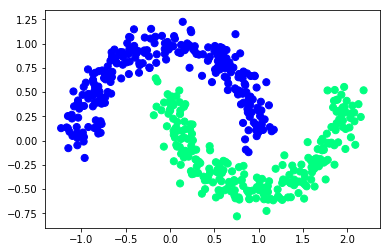

In [3]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
X, y = make_moons(1000,noise=0.1)

X_train, y_train = X[:500],y[:500]
X_test, y_test = X[500:],y[500:]

plt.scatter(X_train[:,0], X_train[:,1], s=50, c=y_train, cmap=plt.cm.winter)
#plt.scatter(X_test[:,0], X_test[:,1], s=20, c=y_test, cmap=plt.cm.Spectral)
#plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

Para evidenciar el pobre funcionamiento de una neurona individual, se genera una configuración linealmente inseparable. En este caso se trata de dos semi círculos de radio √2, uno centrado en (0;0,5) y el otro en (1;0). La entrada ya sea para la neurona o perceptrón, es un conjunto 500 pares ordenados con su respectiva clasificación, un par pertenece a la clase 0 si está en el semicírculo azul y a la clase 1 si está en el semicírculo verde.

Se comparará la performance de una neurona y el perceptrón en el problema de clasificación de los datos en base al error asociado a cada uno de estos.

### Única neurona

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD

n_h=1 #1 neurona

def repetir():
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")

    model.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
    #model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    print("\nTest loss (activation sigmoid) = %f"%model.evaluate(X_test, y_test))
    print("---------------------------------------------------------")

    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="softplus"))
    model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")

    model.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
    #model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    print("\nTest loss (activation softplus) = %f"%model.evaluate(X_test, y_test))
    print("---------------------------------------------------------")

    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="tanh"))
    model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
    model.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
    #model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    print("\nTest loss (activation tanh) = %f"%model.evaluate(X_test, y_test))
    print("---------------------------------------------------------")

for i in range(3):
    print("**Repeticion "+ str(i)+ " del experimento")
    repetir()
#mas arquitecturastpe

**Repeticion 0 del experimento


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=2, activation="sigmoid", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


 32/500 [>.............................] - ETA: 0s
Test loss (activation sigmoid) = 0.255384
---------------------------------------------------------


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=2, activation="softplus", kernel_initializer="uniform")`


 32/500 [>.............................] - ETA: 0s
Test loss (activation softplus) = 0.396541
---------------------------------------------------------


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=2, activation="tanh", kernel_initializer="uniform")`


 32/500 [>.............................] - ETA: 0s
Test loss (activation tanh) = 7.779884
---------------------------------------------------------
**Repeticion 1 del experimento
 32/500 [>.............................] - ETA: 1s
Test loss (activation sigmoid) = 0.255422
---------------------------------------------------------
 32/500 [>.............................] - ETA: 1s
Test loss (activation softplus) = 8.252794
---------------------------------------------------------
 32/500 [>.............................] - ETA: 1s
Test loss (activation tanh) = 2.071308
---------------------------------------------------------
**Repeticion 2 del experimento
 32/500 [>.............................] - ETA: 1s
Test loss (activation sigmoid) = 0.255360
---------------------------------------------------------
 32/500 [>.............................] - ETA: 2s
Test loss (activation softplus) = 0.348412
---------------------------------------------------------
 32/500 [>..........................

Se utilizan distintas funciones de activación no lineales: sigmoidal,softplus y tanh para la neurona. como es un problema de clasificación se intenta minimizar la *loss cross entropy*. El método  de entrenamiento es el *gradiente descendente estocástico* para ambos casos con un tasa de aprendizaje 0.5.

Se ejecuta 3 veces la neurona con las distintas funciones, se imprime por pantalla el error asociado a cada función de activación. La neurona con función de activación sigmoidal para los 3 casos se mantiene en un error similar cercano a 0,27, es decir, mantiene una tendencia. No así para las otras funciones de activación,dado que a cada repetición, sus errores cambian drásticamente en comparación con el anterior(divergen).

Estos errores son relativamente altos para un problema de clasificación, las funciones de activación para esta única neurona no se comportan de una manera óptima ya que no es capaz o no tiene el poder para clasificar el problema dado que es un problema linealmente inseparable. Aunque se use una función de activación no-lineal, ésta es aplicada luego de la discriminante lineal generada por la neurona, por lo tanto, no mejorará su rendimiento.

### c) Perceptron multicapas 

In [12]:
model = Sequential()
model.add(Dense(64, input_dim=2, activation='relu',init='uniform'))
model.add(Dense(64, activation='relu', init='uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
model.fit(X_train, y_train,
          epochs=100,
          batch_size=32, verbose=0)
score = model.evaluate(X_test, y_test)
print("\nTest loss error (activation sigmoid) = %f"%score)
print("---------------------------------------------------------")


#Sigmoidal
perceptron = Sequential()
perceptron.add(Dense(64,input_dim=X_train.shape[1], init='uniform',activation="sigmoid"))
perceptron.add(Dense(64,init='uniform',activation="sigmoid"))
perceptron.add(Dense(1, init='uniform',activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
print("\nTest loss error (activation sigmoid) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")

#Softplus
perceptron = Sequential()
perceptron.add(Dense(64, input_dim=X_train.shape[1], init='uniform',activation="softplus"))
perceptron.add(Dense(64, init='uniform',activation="softplus"))
perceptron.add(Dense(1, init='uniform',activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest loss error (activation softplus) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")

#Tanh
perceptron = Sequential()
perceptron.add(Dense(64, input_dim=X_train.shape[1], init='uniform',activation="tanh"))
perceptron.add(Dense(64,init='uniform',activation="tanh"))
perceptron.add(Dense(1, init='uniform',activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest loss error  (activation tanh) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")

#Relu
perceptron = Sequential()
perceptron.add(Dense(64, input_dim=X_train.shape[1], init='uniform',activation="relu"))
perceptron.add(Dense(64, init='uniform',activation="relu"))
perceptron.add(Dense(1,activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest Test loss error  (activation relu) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=2, activation="relu", kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  app.launch_new_instance()


500/500 [==============================] - 1s      

Test loss error (activation sigmoid) = 0.002658
---------------------------------------------------------


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=2, activation="sigmoid", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="sigmoid", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


480/500 [===========================>..] - ETA: 0s 
Test loss error (activation sigmoid) = 8.252465
---------------------------------------------------------


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=2, activation="softplus", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="softplus", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


384/500 [======================>.......] - ETA: 0s 
Test loss error (activation softplus) = 7.779884
---------------------------------------------------------


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=2, activation="tanh", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="tanh", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


448/500 [=========================>....] - ETA: 0s 
Test loss error  (activation tanh) = 0.261912
---------------------------------------------------------


/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:46: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=2, activation="relu", kernel_initializer="uniform")`
/home/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`


480/500 [===========================>..] - ETA: 0s 
Test Test loss error  (activation relu) = 2.452696
---------------------------------------------------------


En la celda anterior, se utiliza un perceptrón con 2 capas escondidas, cada una con 64 neuronas con el mismo método de entrenamiento. Se observa una baja considerable de los errores, debido a por la arquitectura de la red. Con la incorporación de capas, las neuronas ganan capacidad para aprender a representar el problema, con esto, no necesariamente utilizan el vector de entrada y pesos como una función lineal.

A pesar de esto hay algunas funciones de activacion que dan valores raros ya que ......

¿Porq pasa eso?

Test loss error (activation relu) = 0.002658 
Test Test loss error  (activation relu) = 2.452696